In [1]:
!pip install pytorch_pretrained_bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 769.5 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-man

In [2]:
!pip install pyarabic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 1.6 MB/s eta 0:00:00


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from keras import backend as K
import pandas as pd
from keras.layers import LSTM, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GRU
from tensorflow.keras.layers import Embedding
from keras.models import Model
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from pyarabic import araby
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import keras
from pytorch_pretrained_bert.modeling import BertModel
from tensorflow.keras.models import Sequential,load_model
import transformers
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import re
import numpy as np
from pyarabic import araby
from tensorflow.keras.layers import Embedding
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GRU, Embedding, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from transformers import BertModel

## DarijaBERT

In [7]:
import pandas as pd
import numpy as np
import re
import keras
from keras import backend as K
from keras.layers import (LSTM, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GRU, Bidirectional)
from tensorflow.keras.layers import Embedding
from keras.models import Model, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from transformers import BertModel, BertTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pyarabic import araby
from keras.callbacks import EarlyStopping

def clean(text):
    text = text.replace("<br/>", " ")
    strip_special_chars = re.compile(u'[^\u0621-\u064a ]')
    return re.sub(strip_special_chars, " ", text)

def process(text):
    text = araby.strip_tashkeel(text)
    text = re.sub('\ـ+', ' ', text)
    text = re.sub('\ر+', 'ر', text)
    text = re.sub('\اا+', 'ا', text)
    text = re.sub('\ووو+', 'و', text)
    text = re.sub('\ههه+', 'ههه', text)
    text = re.sub('\ةة+', 'ة', text)
    text = re.sub('\ييي+', 'ي', text)
    text = re.sub('أ', 'ا', text)
    text = re.sub('آ', 'ا', text)
    text = re.sub('إ', 'ا', text)
    text = re.sub('ة', 'ه', text)
    text = re.sub('ى', 'ي', text)
    text = " ".join(text.split())
    return text

def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data['clean_text'] = data['text'].apply(clean)
    data['clean_text_process'] = data['clean_text'].apply(process)
    return data

def prepare_data(data):
    text = data['clean_text_process']
    sentiment = data['sentiment']
    y = np.array(list(map(lambda x: 1 if x == "Positive" else 0, sentiment)))
    # 80% train + validation and 20% test
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(text, y, test_size=0.2, random_state=45)
    #70% train and 10% validation
    X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.125, random_state=45)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test

def get_bert_embed_matrix(BERT_FP):
    model = BertModel.from_pretrained(BERT_FP)
    embedding_matrix = model.embeddings.word_embeddings.weight.data.numpy()
    return embedding_matrix

def define_embedding_layer(embedding_matrix):
    return Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)

def CNN(input_shape):
    X_indices = Input(input_shape)
    embeddings = embedding_layer(X_indices)
    X = Conv1D(512, 3, activation='relu')(embeddings)
    X = MaxPooling1D(3)(X)
    X = Conv1D(256, kernel_size=1, activation='relu')(X)
    X = Dropout(0.8)(X)
    X = MaxPooling1D(3)(X)
    X = GlobalMaxPooling1D()(X)
    X = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    return model

BERT_FP = 'SI2M-Lab/DarijaBERT'
file_path = '/content/drive/MyDrive/dataset.csv'
data = load_and_preprocess_data(file_path)
X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_data(data)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index
print(len(words_to_index))
maxLen = 150

X_train_indices = tokenizer.texts_to_sequences(X_train)
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
X_val_indices = tokenizer.texts_to_sequences(X_val)
X_val_indices = pad_sequences(X_val_indices, maxlen=maxLen, padding='post')
X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

embedding_matrix = get_bert_embed_matrix(BERT_FP)
embedding_layer = define_embedding_layer(embedding_matrix)

157094


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


pytorch_model.bin:   0%|          | 0.00/836M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# CNN

In [8]:
model1 = CNN((maxLen,))
print(model1.summary())
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history1=model1.fit(X_train_indices, Y_train, batch_size=64, epochs=40, validation_data=(X_val_indices, Y_val), callbacks=[early_stopping])
model1.save('model1.h5')
print("model 1 CNN saved")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 768)          61440000  
                                                                 
 conv1d (Conv1D)             (None, 148, 512)          1180160   
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 512)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 49, 256)           131328    
                                                                 
 dropout (Dropout)           (None, 49, 256)           0         
                                                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model 1 CNN saved


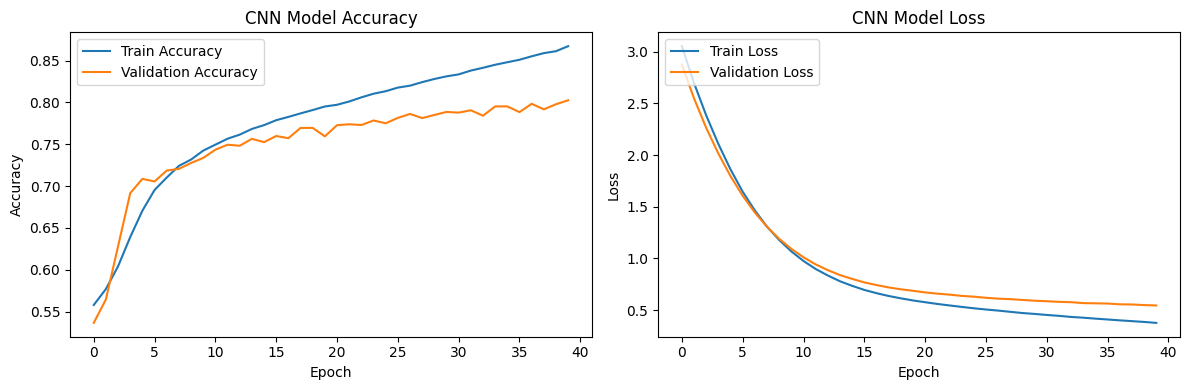

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      3927
           1       0.82      0.79      0.80      4073

    accuracy                           0.80      8000
   macro avg       0.80      0.80      0.80      8000
weighted avg       0.80      0.80      0.80      8000



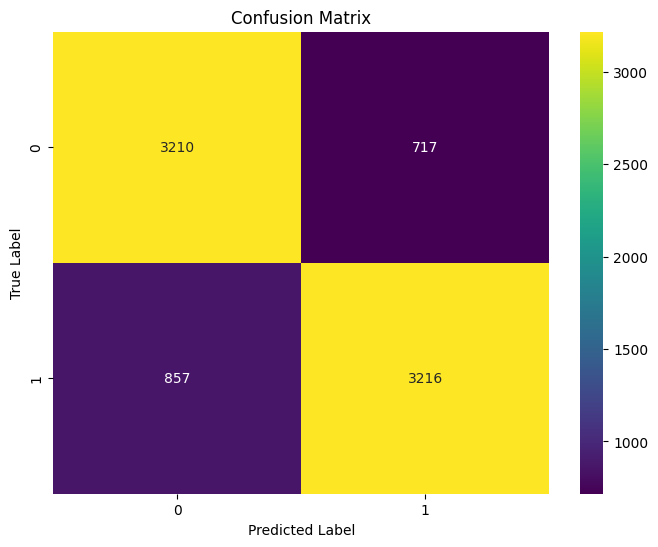

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


Y_pred_prob = model1.predict(X_test_indices)
Y_pred = (Y_pred_prob > 0.5).astype(int)

print(classification_report(Y_test, Y_pred, target_names=['0', '1']))


cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# LSTM

In [ ]:
from keras.layers import (LSTM, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GRU, Bidirectional, BatchNormalization)


In [ ]:
def LSTM_(input_shape):
    X_indices = Input(input_shape)
    embeddings = embedding_layer(X_indices)
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.6)(X)
    X = LSTM(128)(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    return model


model2 = LSTM_((150,))
print(model2.summary())
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history2 = model2.fit(X_train_indices, Y_train, batch_size=64, epochs=25, validation_data=(X_val_indices, Y_val))
model2.save('model2.h5')
print("model 2 LSTM saved")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 768)          61440000  
                                                                 
 lstm_10 (LSTM)              (None, 150, 128)          459264    
                                                                 
 dropout_16 (Dropout)        (None, 150, 128)          0         
                                                                 
 lstm_11 (LSTM)              (None, 128)               131584    
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 62030977 (236.63 MB)
Trainable params: 590977

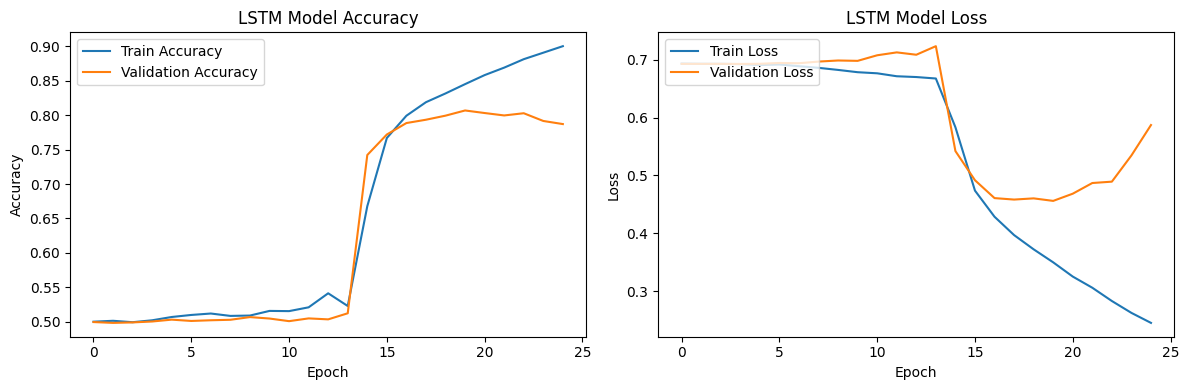

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      3927
           1       0.85      0.82      0.83      4073

    accuracy                           0.83      8000
   macro avg       0.83      0.83      0.83      8000
weighted avg       0.83      0.83      0.83      8000



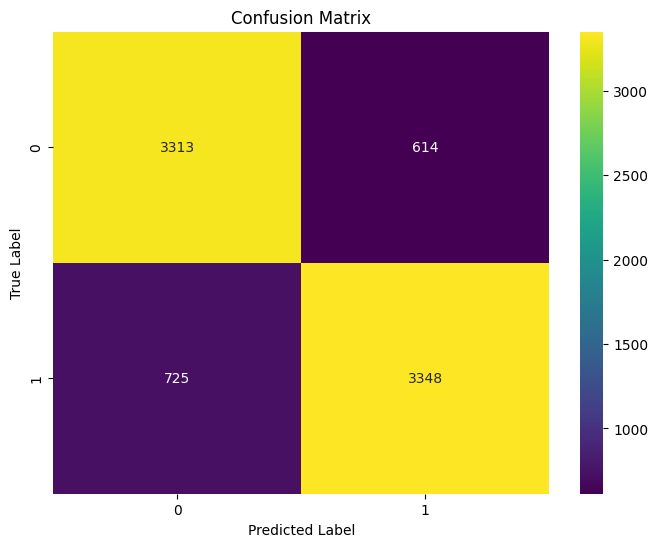

In [13]:
Y_pred_prob = model2.predict(X_test_indices)
Y_pred = (Y_pred_prob > 0.5).astype(int)

print(classification_report(Y_test, Y_pred, target_names=['0', '1']))

cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# BiLSTM

In [ ]:
def BiLSTM(input_shape):
    X_indices = Input(input_shape)
    embeddings = embedding_layer(X_indices)
    X = Bidirectional(LSTM(128, return_sequences=True))(embeddings)
    X = Dropout(0.8)(X)
    X = Bidirectional(LSTM(128, return_sequences=False))(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    return model

model3 = BiLSTM((150,))
print(model3.summary())
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history3 = model3.fit(X_train_indices, Y_train, batch_size=64, epochs=30, validation_data=(X_val_indices, Y_val))
model3.save('model3.h5')
print("model 3 BiLSTM saved")

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 768)          61440000  
                                                                 
 bidirectional_6 (Bidirecti  (None, 150, 256)          918528    
 onal)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 150, 256)          0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 1)                 257

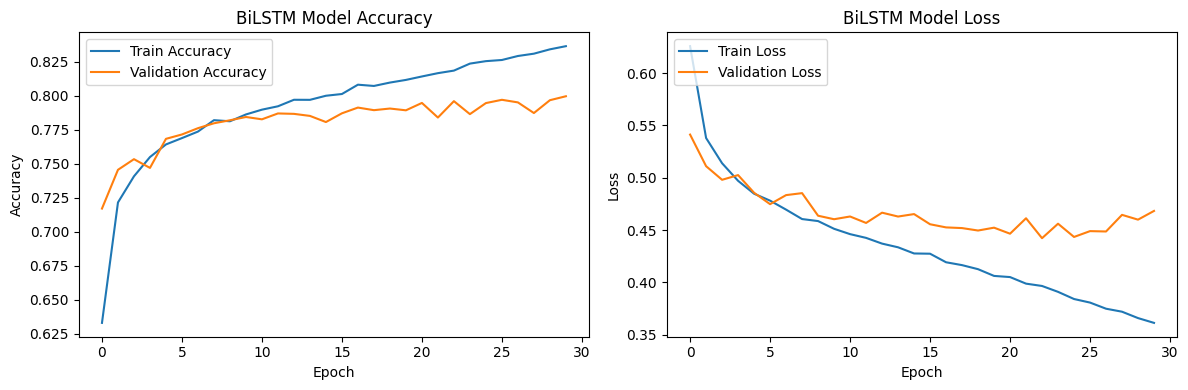

In [ ]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('BiLSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('BiLSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      3927
           1       0.80      0.82      0.81      4073

    accuracy                           0.80      8000
   macro avg       0.80      0.80      0.80      8000
weighted avg       0.80      0.80      0.80      8000



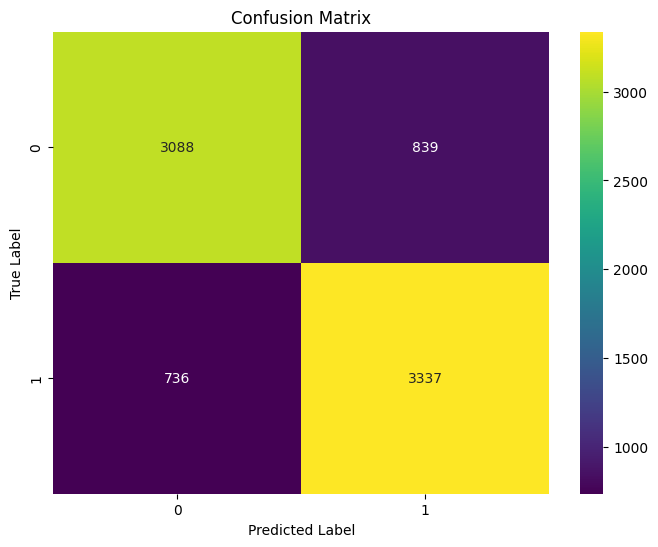

In [15]:
Y_pred_prob = model3.predict(X_test_indices)
Y_pred = (Y_pred_prob > 0.5).astype(int)

print(classification_report(Y_test, Y_pred, target_names=['0', '1']))

cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## GRU

In [ ]:
def GRU_(input_shape):
    X_indices = Input(input_shape)
    embeddings = embedding_layer(X_indices)
    X = GRU(128, return_sequences=True)(embeddings)
    X = Dropout(0.6)(X)
    X = GRU(128, return_sequences=True)(X)
    X = Dropout(0.6)(X)
    X = Dense(1)(X)
    X = Reshape((-1,))(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    return model

from keras.layers import Reshape
model4 = GRU_((150,))
print(model4.summary())
model4.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history4 = model4.fit(X_train_indices, Y_train, batch_size=64, epochs=40, validation_data=(X_val_indices, Y_val))
model4.save('model4.h5')
print("model 4 GRU saved")

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 768)          61440000  
                                                                 
 gru (GRU)                   (None, 150, 128)          344832    
                                                                 
 dropout_18 (Dropout)        (None, 150, 128)          0         
                                                                 
 gru_1 (GRU)                 (None, 150, 128)          99072     
                                                                 
 dropout_19 (Dropout)        (None, 150, 128)          0         
                                                                 
 dense_14 (Dense)            (None, 150, 1)            129 

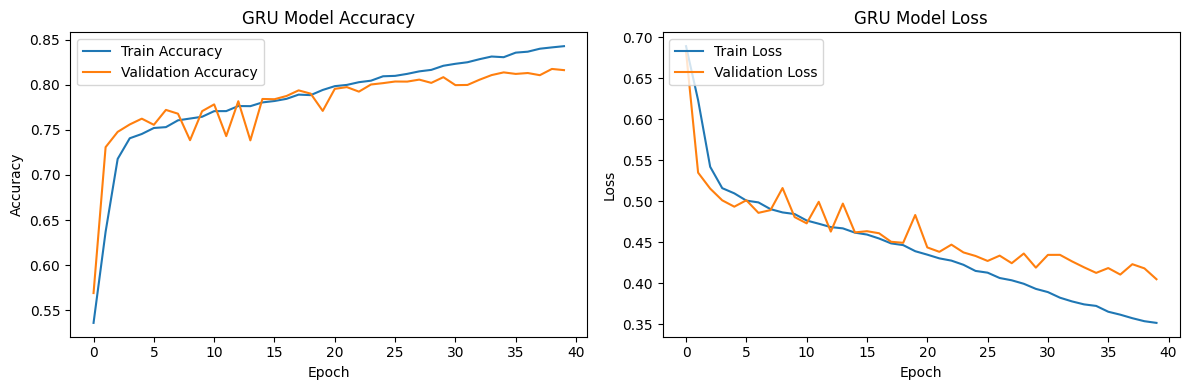

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], label='Train Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      3927
           1       0.80      0.82      0.81      4073

    accuracy                           0.80      8000
   macro avg       0.80      0.80      0.80      8000
weighted avg       0.80      0.80      0.80      8000



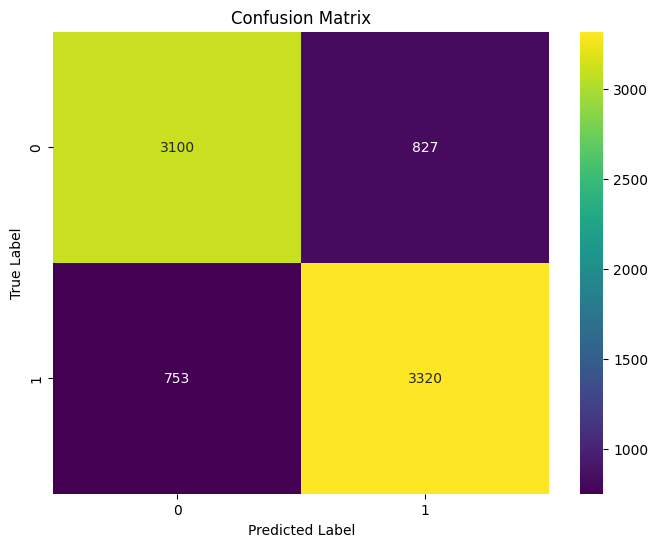

In [16]:
Y_pred_prob = model4.predict(X_test_indices)
Y_pred = (Y_pred_prob > 0.5).astype(int)

print(classification_report(Y_test, Y_pred, target_names=['0', '1']))


cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Randomized SearchCV

## CNN

In [ ]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 29.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
import tensorflow as tf
from keras.layers import LSTM, Dropout, Dense, Input, Bidirectional, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Model
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score

maxLen = 150

def create_model(optimizer='adam', dropout_rate=0.5):
    X_indices = Input((maxLen,))
    embeddings = embedding_layer(X_indices)
    X = Conv1D(512, 3, activation='relu')(embeddings)
    X = MaxPooling1D(3)(X)
    X = Conv1D(256, kernel_size=1, activation='relu')(X)
    X = Dropout(dropout_rate)(X)
    X = MaxPooling1D(3)(X)
    X = GlobalMaxPooling1D()(X)
    X = Dense(256, activation='relu')(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, optimizer='adam', dropout_rate=0.5)

# Define the random search parameters
param_dist = {
    'model__optimizer': ['adam', 'nadam'],
    'model__dropout_rate': [0.5, 0.6, 0.7],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

# Perform the random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=1, cv=2, n_jobs=1, random_state=42)
random_search_result = random_search.fit(X_train_indices, Y_train)

# Summarize results
print(f"Best: {random_search_result.best_score_} using {random_search_result.best_params_}")
means = random_search_result.cv_results_['mean_test_score']
stds = random_search_result.cv_results_['std_test_score']
params = random_search_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.9551 - loss: 0.1089
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.9963 - loss: 0.0123
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9959 - loss: 0.0169
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9977 - loss: 0.0092
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.9977 - loss: 0.0073
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9977 - loss: 0.0093
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9980 - loss: 0.0079
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.9961 - loss: 0.0111
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9983 - loss: 0.0055
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9986 - loss: 0.0051
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9983 - loss: 0.0070
Epoch 12/20
500/500 ━━━━━━━━━━

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      3927
           1       0.81      0.85      0.83      4073

    accuracy                           0.82      8000
   macro avg       0.82      0.82      0.82      8000
weighted avg       0.82      0.82      0.82      8000



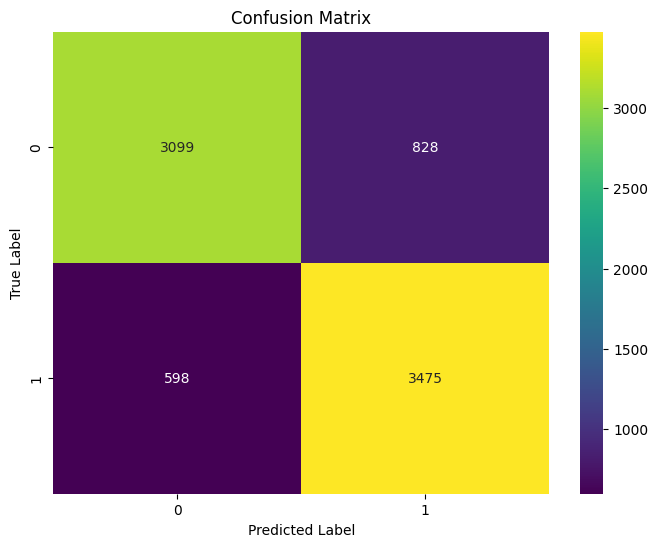

In [18]:
Y_pred_prob = random_search_result.predict(X_test_indices)
Y_pred = (Y_pred_prob > 0.5).astype(int)

print(classification_report(Y_test, Y_pred, target_names=['0', '1']))

cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# cross_val_predict

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2487
           1       0.90      0.91      0.90      2513

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



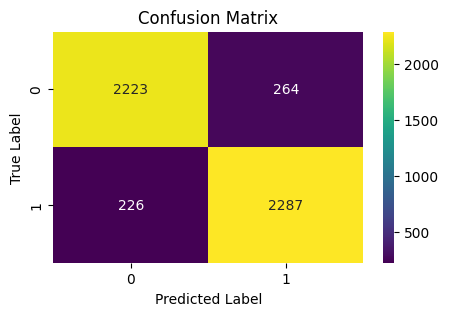

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Input
from keras.models import Model
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def create_model():
    input_shape = (150,)
    X_indices = Input(input_shape)
    embeddings = embedding_layer(X_indices)
    X = Conv1D(512, 3, activation='relu')(embeddings)
    X = MaxPooling1D(3)(X)
    X = Conv1D(256, kernel_size=1, activation='relu')(X)
    X = Dropout(0.8)(X)
    X = MaxPooling1D(3)(X)
    X = GlobalMaxPooling1D()(X)
    X = Dense(256, activation='relu')(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, epochs=5, batch_size=32, verbose=0)

sample_size = 5000
indices = np.random.choice(len(X_test_indices), sample_size, replace=False)
X_test_sample = X_test_indices[indices]
Y_test_sample = Y_test[indices]

y_pred = cross_val_predict(model, X_test_sample, Y_test_sample, cv=3)

conf_matrix = confusion_matrix(Y_test_sample, y_pred)
class_report = classification_report(Y_test_sample, y_pred)
print(f"Classification Report:\n{class_report}")
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## LSTM

In [ ]:
def create_model(optimizer='adam', dropout_rate=0.5):
    X_indices = Input((maxLen,))
    embeddings = embedding_layer(X_indices)
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(dropout_rate)(X)
    X = LSTM(128)(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, optimizer='adam', dropout_rate=0.5)

param_dist = {
    'model__optimizer': ['adam', 'nadam'],
    'model__dropout_rate': [0.5, 0.6, 0.7],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=1, cv=2, n_jobs=1, random_state=42)
random_search_result = random_search.fit(X_train_indices, Y_train)

print(f"Best: {random_search_result.best_score_} using {random_search_result.best_params_}")
means = random_search_result.cv_results_['mean_test_score']
stds = random_search_result.cv_results_['std_test_score']
params = random_search_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 51ms/step - accuracy: 0.6650 - loss: 0.5513
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.9611 - loss: 0.1176
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.9899 - loss: 0.0342
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.9968 - loss: 0.0102
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.9977 - loss: 0.0087
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9981 - loss: 0.0043
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.9983 - loss: 0.0073
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.9915 - loss: 0.0311
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.9964 - loss: 0.0126
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.9985 - loss: 0.0061
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.9988 - loss: 0.0027
Epoch 12/20
500/500 ━━━━━━━━━━

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      3927
           1       0.85      0.82      0.83      4073

    accuracy                           0.83      8000
   macro avg       0.83      0.83      0.83      8000
weighted avg       0.83      0.83      0.83      8000



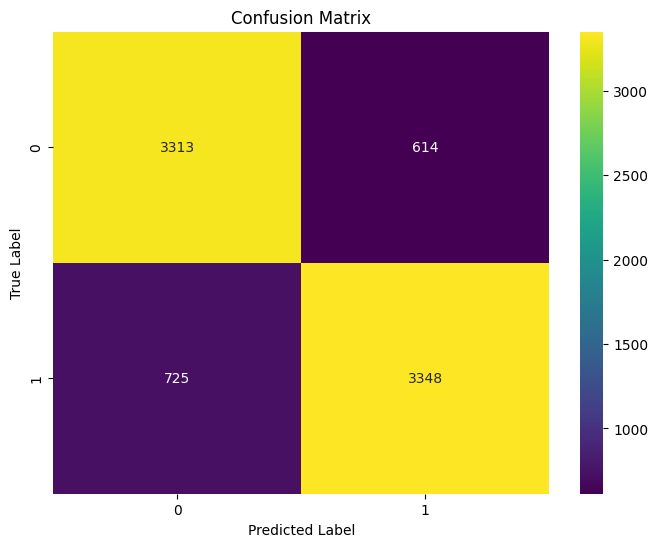

In [20]:
Y_pred_prob = random_search_result.predict(X_test_indices)
Y_pred = (Y_pred_prob > 0.5).astype(int)

print(classification_report(Y_test, Y_pred, target_names=['0', '1']))

cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# cross_validation

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      2405
           1       0.92      0.96      0.94      2595

    accuracy                           0.94      5000
   macro avg       0.94      0.93      0.94      5000
weighted avg       0.94      0.94      0.94      5000



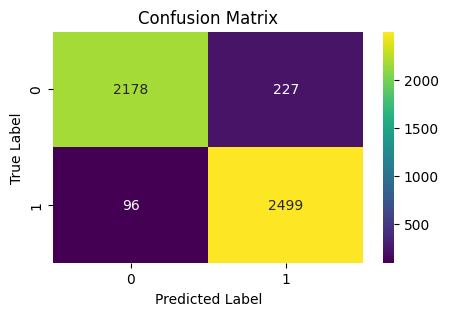

In [ ]:
def create_model():
    input_shape = (150,)
    X_indices = Input(input_shape)
    embeddings = embedding_layer(X_indices)
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.6)(X)
    X = LSTM(128)(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, epochs=5, batch_size=32, verbose=0)

sample_size = 5000
indices = np.random.choice(len(X_test_indices), sample_size, replace=False)
X_test_sample = X_test_indices[indices]
Y_test_sample = Y_test[indices]

y_pred = cross_val_predict(model, X_test_sample, Y_test_sample, cv=3)

conf_matrix = confusion_matrix(Y_test_sample, y_pred)
class_report = classification_report(Y_test_sample, y_pred)
print(f"Classification Report:\n{class_report}")
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## BiLSTM

In [ ]:

def create_model(optimizer='adam', dropout_rate=0.5):
    X_indices = Input((maxLen,))
    embeddings = embedding_layer(X_indices)
    X = Bidirectional(LSTM(128, return_sequences=True))(embeddings)
    X = Dropout(dropout_rate)(X)
    X = Bidirectional(LSTM(128))(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, optimizer='adam', dropout_rate=0.5)

param_dist = {
    'model__optimizer': ['adam', 'nadam'],
    'model__dropout_rate': [0.5, 0.6, 0.7],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=1, cv=2, n_jobs=1, random_state=42)
random_search_result = random_search.fit(X_train_indices, Y_train)

print(f"Best: {random_search_result.best_score_} using {random_search_result.best_params_}")
means = random_search_result.cv_results_['mean_test_score']
stds = random_search_result.cv_results_['std_test_score']
params = random_search_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - accuracy: 0.7378 - loss: 0.5090
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 66ms/step - accuracy: 0.9284 - loss: 0.2023
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.9693 - loss: 0.0918
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.9848 - loss: 0.0458
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.9937 - loss: 0.0215
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.9949 - loss: 0.0163
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.9973 - loss: 0.0069
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.9954 - loss: 0.0126
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.9968 - loss: 0.0087
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.9978 - loss: 0.0072
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.9984 - loss: 0.0052
Epoch 12/20
500/500 ━━━━━━━━━━

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      3927
           1       0.82      0.84      0.83      4073

    accuracy                           0.83      8000
   macro avg       0.83      0.83      0.83      8000
weighted avg       0.83      0.83      0.83      8000



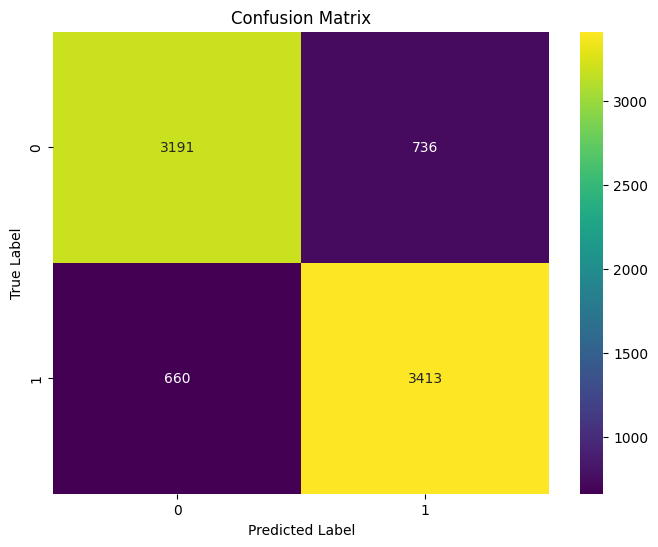

In [26]:
Y_pred_prob = random_search_result.predict(X_test_indices)
Y_pred = (Y_pred_prob > 0.5).astype(int)


print(classification_report(Y_test, Y_pred, target_names=['0', '1']))


cm = confusion_matrix(Y_test, Y_pred)


plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# cross_val_predict

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2477
           1       0.92      0.93      0.93      2523

    accuracy                           0.93      5000
   macro avg       0.93      0.92      0.92      5000
weighted avg       0.93      0.93      0.92      5000



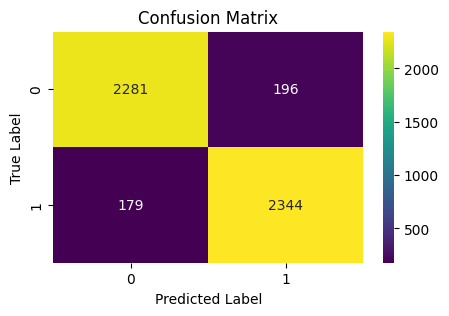

In [ ]:
def create_model():
    input_shape = (150,)
    X_indices = Input(input_shape)
    embeddings = embedding_layer(X_indices)
    X = Bidirectional(LSTM(128, return_sequences=True))(embeddings)
    X = Dropout(0.6)(X)
    X = Bidirectional(LSTM(128))(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, epochs=5, batch_size=32, verbose=0)

sample_size = 5000
indices = np.random.choice(len(X_test_indices), sample_size, replace=False)
X_test_sample = X_test_indices[indices]
Y_test_sample = Y_test[indices]

y_pred = cross_val_predict(model, X_test_sample, Y_test_sample, cv=3)

conf_matrix = confusion_matrix(Y_test_sample, y_pred)
class_report = classification_report(Y_test_sample, y_pred)
print(f"Classification Report:\n{class_report}")

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## GRU

In [ ]:
def create_model(optimizer='adam', dropout_rate=0.5):
    X_indices = Input((maxLen,))
    embeddings = embedding_layer(X_indices)
    X = GRU(128, return_sequences=True)(embeddings)
    X = Dropout(dropout_rate)(X)
    X = GRU(128, return_sequences=True)(X)
    X = Dropout(dropout_rate)(X)
    X = Dense(1)(X)
    X = Reshape((-1,))(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, optimizer='adam', dropout_rate=0.5)

param_dist = {
    'model__optimizer': ['adam', 'nadam'],
    'model__dropout_rate': [0.5, 0.6, 0.7],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=1, cv=2, n_jobs=1, random_state=42)
random_search_result = random_search.fit(X_train_indices, Y_train)

print(f"Best: {random_search_result.best_score_} using {random_search_result.best_params_}")
means = random_search_result.cv_results_['mean_test_score']
stds = random_search_result.cv_results_['std_test_score']
params = random_search_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - accuracy: 0.7853 - loss: 0.3949
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.9990 - loss: 0.0032
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.9989 - loss: 0.0039
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.9982 - loss: 0.0053
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.9993 - loss: 0.0033
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.9993 - loss: 0.0014
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.9992 - loss: 0.0024
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.9996 - loss: 0.0014
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.9982 - loss: 0.0053
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.9990 - loss: 0.0032
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.9993 - loss: 0.0023
Epoch 12/20
500/500 ━━━━━━━━━━

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      3927
           1       0.84      0.81      0.82      4073

    accuracy                           0.82      8000
   macro avg       0.82      0.82      0.82      8000
weighted avg       0.82      0.82      0.82      8000



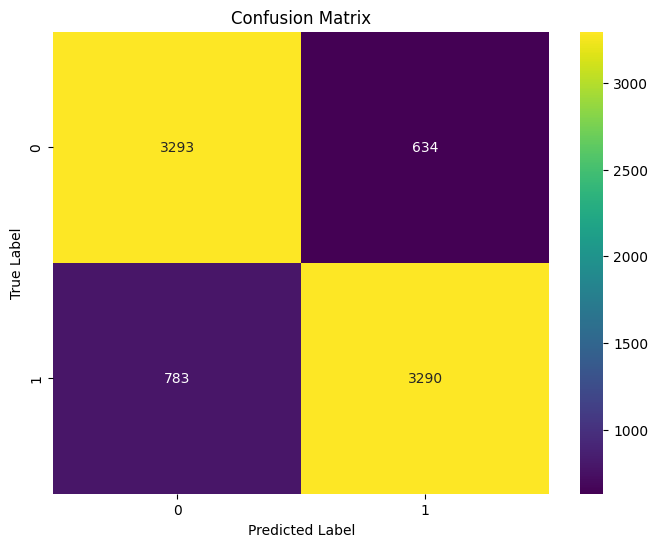

In [22]:
Y_pred_prob = random_search_result.predict(X_test_indices)
Y_pred = (Y_pred_prob > 0.5).astype(int)

print(classification_report(Y_test, Y_pred, target_names=['0', '1']))

cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Cross_val_predict

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2447
           1       0.96      0.94      0.95      2553

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



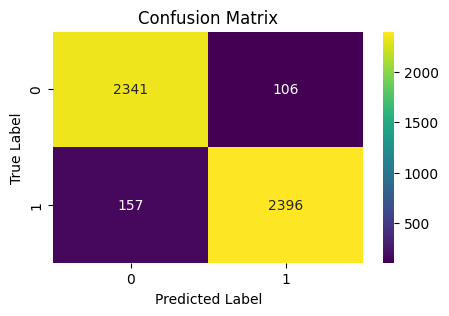

In [ ]:
def create_model():
    input_shape = (150,)
    X_indices = Input(input_shape)
    embeddings = embedding_layer(X_indices)
    X = GRU(128, return_sequences=True)(embeddings)
    X = Dropout(0.6)(X)
    X = GRU(128, return_sequences=True)(X)
    X = Dropout(0.6)(X)
    X = Dense(1)(X)
    X = Reshape((-1,))(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, epochs=5, batch_size=32, verbose=0)

sample_size = 5000
indices = np.random.choice(len(X_test_indices), sample_size, replace=False)
X_test_sample = X_test_indices[indices]
Y_test_sample = Y_test[indices]

y_pred = cross_val_predict(model, X_test_sample, Y_test_sample, cv=3)

conf_matrix = confusion_matrix(Y_test_sample, y_pred)
class_report = classification_report(Y_test_sample, y_pred)
print(f"Classification Report:\n{class_report}")

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Logistic Regrission

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

dependencies = {
    'f1_m': f1_m
}

In [ ]:
# load models from file
def load_all_models():
  all_models = list()
  model1 = load_model('model1.h5', custom_objects=dependencies)
  model2 = load_model('model2.h5', custom_objects=dependencies)
  model3 = load_model('model3.h5', custom_objects=dependencies)
  model4 = load_model('model4.h5', custom_objects=dependencies)
  all_models.append(model1)
  all_models.append(model2)
  all_models.append(model3)
  all_models.append(model4)
  print('>loaded models ')
  return all_models

In [ ]:
def stacked_dataset(members, inputX):
    stackX = None
    preds1 = members[0].predict(inputX)
    preds2 = members[1].predict(inputX)
    preds1_ = preds1.reshape((preds1.shape[0], preds1.shape[1], 1))
    preds2_ = preds2.reshape((preds2.shape[0], preds2.shape[1], 1))
    preds3 = members[2].predict(inputX)
    preds4 = members[3].predict(inputX)
    preds3_ = preds3.reshape((preds3.shape[0], preds3.shape[1], 1))
    preds4_ = preds4.reshape((preds4.shape[0], preds4.shape[1], 1))
    stackX = np.column_stack((preds1_, preds2_, preds3_, preds4_))
    print('stackX shape: ', stackX.shape)
    stackX = stackX.reshape((stackX.shape[0], (stackX.shape[1]*stackX.shape[2])))
    return stackX

In [ ]:
def fit_stacked_model(members, inputX, inputy):
    stackedX = stacked_dataset(members, inputX)
    print("Shape of stackedX:", stackedX.shape)
    print("Shape of inputy:", inputy.shape)
    model = LogisticRegression(solver='lbfgs', max_iter=100) #meta learner
    model.fit(stackedX, inputy)
    return model

In [ ]:
members = load_all_models()
print('Loaded the models')

modelStacked = fit_stacked_model(members, X_train_indices, Y_train)
print('stacked model fited')

>loaded models 
Loaded the models
1247/1247 [==============================] - 10s 7ms/step
stackX shape:  (39891, 4, 1)
Shape of stackedX: (39891, 4)
Shape of inputy: (39891,)
stacked model fited


              precision    recall  f1-score   support

           0       0.79      0.84      0.81      3927
           1       0.83      0.79      0.81      4073

    accuracy                           0.81      8000
   macro avg       0.81      0.81      0.81      8000
weighted avg       0.81      0.81      0.81      8000



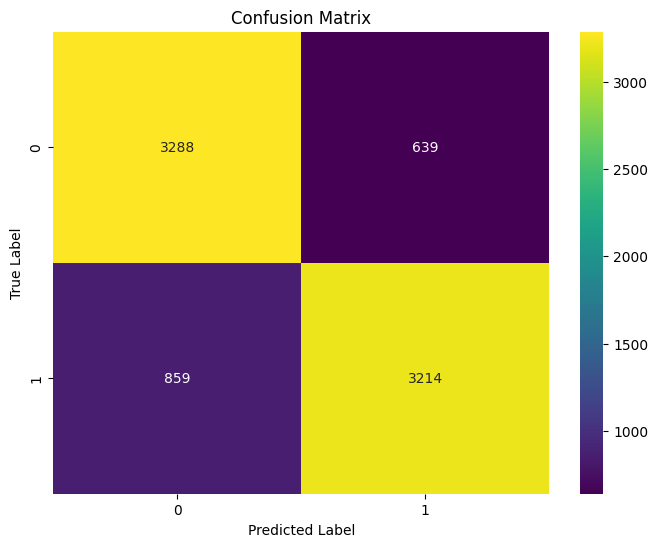

In [24]:
def stacked_prediction(members, model, inputX):
    stackedX = stacked_dataset(members, inputX)
    yhat = model.predict(stackedX)
    return yhat

yhat = stacked_prediction(members, modelStacked, X_test_indices)



class_report = classification_report(Y_test, yhat, target_names=['0', '1'])
print(f'Classification Report:\n{class_report}')

conf_matrix = confusion_matrix(Y_test, yhat)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# RandomizedSearchCV

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

def fit_stacked_model_with_search(members, inputX, inputy):
    stackedX = stacked_dataset(members, inputX)

    model = LogisticRegression(solver='lbfgs', max_iter=100)

    param_dist = {
        'C': np.logspace(-4, 4, 20),
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    }

    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=-1)
    random_search_result = random_search.fit(stackedX, inputy)

    print(f"Best: {random_search_result.best_score_} using {random_search_result.best_params_}")
    return random_search_result.best_estimator_

modelStacked = fit_stacked_model_with_search(members, X_train_indices, Y_train)
print('stacked model fitted')

1247/1247 [==============================] - 9s 7ms/step
stackX shape:  (39891, 4, 1)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best: 0.9986964478203104 using {'solver': 'lbfgs', 'penalty': 'l2', 'C': 29.76351441631313}
stacked model fitted


              precision    recall  f1-score   support

           0       0.84      0.81      0.82      3927
           1       0.82      0.85      0.83      4073

    accuracy                           0.83      8000
   macro avg       0.83      0.83      0.83      8000
weighted avg       0.83      0.83      0.83      8000



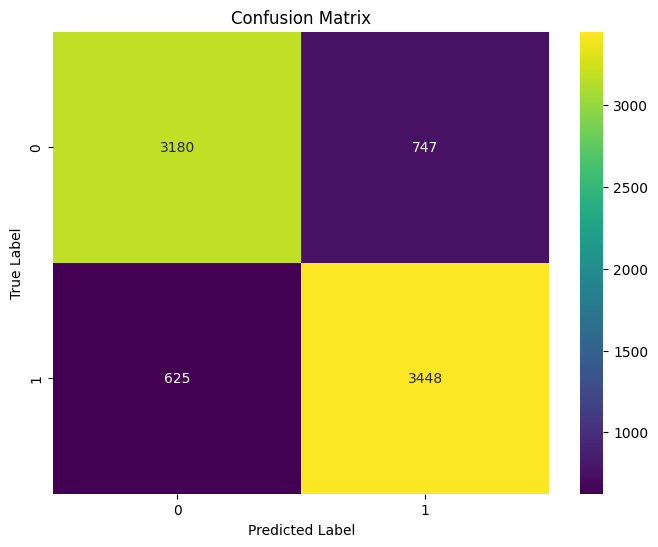

In [28]:
Y_pred_prob = random_search_result.predict(X_test_indices)
Y_pred = (Y_pred_prob > 0.5).astype(int)


print(classification_report(Y_test, Y_pred, target_names=['0', '1']))

cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# cross_val_score

The accuracy score of stacked model is: 0.548079815501855
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.67      0.60      4991
           1       0.56      0.43      0.49      4982

    accuracy                           0.55      9973
   macro avg       0.55      0.55      0.54      9973
weighted avg       0.55      0.55      0.54      9973

Precision: 0.5507561029575022
Recall: 0.548079815501855
F1 Score: 0.541778018017855


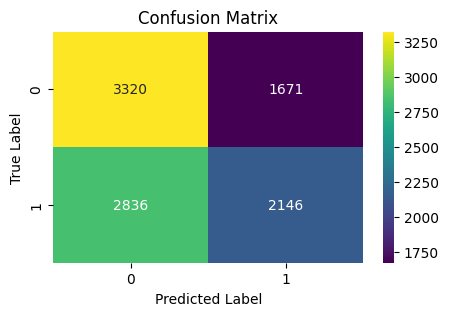

Cross-validated Accuracy: 0.548078873211112


In [ ]:
def stacked_prediction(members, model, inputX):
    stackedX = stacked_dataset(members, inputX)
    yhat = model.predict(stackedX)
    return yhat

y_pred = cross_val_predict(modelStacked, X_test_indices, Y_test, cv=5)

accuracy = accuracy_score(Y_test, y_pred)
print(f'The accuracy score of stacked model is: {accuracy}')

conf_matrix = confusion_matrix(Y_test, y_pred)
class_report = classification_report(Y_test, y_pred, target_names=['0', '1'])
print(f'Classification Report:\n{class_report}')

precision = precision_score(Y_test, y_pred, average='weighted')
recall = recall_score(Y_test, y_pred, average='weighted')
f1 = f1_score(Y_test, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

cross_val_accuracy = cross_val_score(modelStacked, X_test_indices, Y_test, cv=5, scoring='accuracy')
print(f'Cross-validated Accuracy: {cross_val_accuracy.mean()}')


# MLPClassifier

>loaded models 
Loaded the models
1247/1247 [==============================] - 10s 8ms/step
stackX shape:  (39891, 4, 1)
Shape of stackedX: (39891, 4)
Shape of inputy: (39891,)
Stacked model fitted
312/312 [==============================] - 2s 7ms/step
stackX shape:  (9973, 4, 1)
The accuracy score of the stacked model is: 0.8599217888298406
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4991
           1       0.87      0.85      0.86      4982

    accuracy                           0.86      9973
   macro avg       0.86      0.86      0.86      9973
weighted avg       0.86      0.86      0.86      9973

Precision: 0.860110412775281
Recall: 0.8599217888298406
F1 Score: 0.8599017022674117


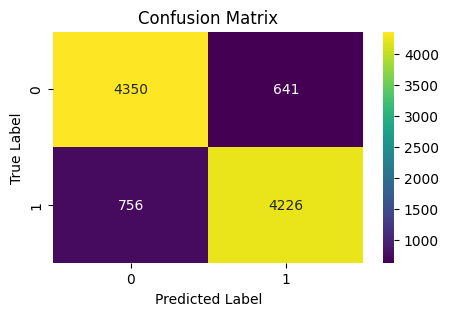

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # Create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    print("Shape of stackedX:", stackedX.shape)
    print("Shape of inputy:", inputy.shape)
    # Fit standalone model using MLPClassifier
    model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, solver='adam', random_state=42)
    model.fit(stackedX, inputy)
    return model

# Load all models
members = load_all_models()
print('Loaded the models')

# Fit the stacked model
modelStacked = fit_stacked_model(members, train_indices, Y_train)
print('Stacked model fitted')

# Function to make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # Create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # Make a prediction
    yhat = model.predict(stackedX)
    return yhat

# Evaluate the proposed model (MDSA) on the test set
yhat = stacked_prediction(members, modelStacked, test_indices)

# Calculate accuracy
accuracy = accuracy_score(Y_test, yhat)
print(f'The accuracy score of the stacked model is: {accuracy}')

# Generate classification report
class_report = classification_report(Y_test, yhat, target_names=['0', '1'])
print(f'Classification Report:\n{class_report}')

# Additional metrics: Precision, Recall, F1-score
precision = precision_score(Y_test, yhat, average='weighted')
recall = recall_score(Y_test, yhat, average='weighted')
f1 = f1_score(Y_test, yhat, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Generate confusion matrix
conf_matrix = confusion_matrix(Y_test, yhat)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# RandomizedSearchCV

>loaded models 
Loaded the models
1247/1247 [==============================] - 11s 8ms/step
stackX shape:  (39891, 4, 1)
Shape of stackedX: (39891, 4)
Shape of inputy: (39891,)
Best parameters found: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 50), 'alpha': 0.05, 'activation': 'tanh'}
Stacked model fitted
312/312 [==============================] - 3s 9ms/step
stackX shape:  (9973, 4, 1)
The accuracy score of the stacked model is: 0.8608242254086033
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4991
           1       0.87      0.85      0.86      4982

    accuracy                           0.86      9973
   macro avg       0.86      0.86      0.86      9973
weighted avg       0.86      0.86      0.86      9973

Precision: 0.8610739313393424
Recall: 0.8608242254086033
F1 Score: 0.8607981763596582


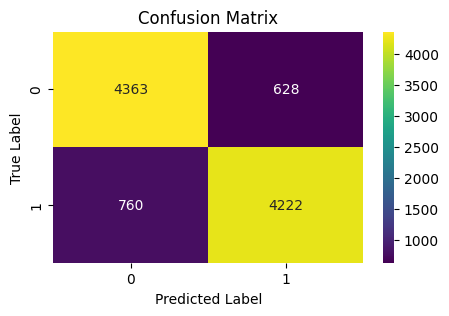

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # Create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    print("Shape of stackedX:", stackedX.shape)
    print("Shape of inputy:", inputy.shape)
    # Define the MLPClassifier
    model = MLPClassifier()
    # Define the parameter grid
    param_dist = {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 100)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'adaptive'],
    }
    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1, random_state=42)
    random_search.fit(stackedX, inputy)
    print(f"Best parameters found: {random_search.best_params_}")
    # Fit the best model
    best_model = random_search.best_estimator_
    best_model.fit(stackedX, inputy)
    return best_model

# Load all models
members = load_all_models()
print('Loaded the models')

# Fit the stacked model
modelStacked = fit_stacked_model(members, train_indices, Y_train)
print('Stacked model fitted')

# Function to make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # Create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # Make a prediction
    yhat = model.predict(stackedX)
    return yhat

# Evaluate the proposed model (MDSA) on the test set
yhat = stacked_prediction(members, modelStacked, test_indices)

# Calculate accuracy
accuracy = accuracy_score(Y_test, yhat)
print(f'The accuracy score of the stacked model is: {accuracy}')

# Generate classification report
class_report = classification_report(Y_test, yhat, target_names=['0', '1'])
print(f'Classification Report:\n{class_report}')

# Additional metrics: Precision, Recall, F1-score
precision = precision_score(Y_test, yhat, average='weighted')
recall = recall_score(Y_test, yhat, average='weighted')
f1 = f1_score(Y_test, yhat, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Generate confusion matrix
conf_matrix = confusion_matrix(Y_test, yhat)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# cross_val_score

>loaded models 
Loaded the models
1247/1247 [==============================] - 10s 8ms/step
stackX shape:  (39891, 4, 1)
Shape of stackedX: (39891, 4)
Shape of inputy: (39891,)
Cross-validation scores: [0.99899737 0.99849586 0.99837052 0.9988719  0.9988719 ]
Mean cross-validation score: 0.9987215092161421
Stacked model fitted
312/312 [==============================] - 2s 7ms/step
stackX shape:  (9973, 4, 1)
The accuracy score of the stacked model is: 0.8603228717537351
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4991
           1       0.87      0.85      0.86      4982

    accuracy                           0.86      9973
   macro avg       0.86      0.86      0.86      9973
weighted avg       0.86      0.86      0.86      9973

Precision: 0.8604682070238138
Recall: 0.8603228717537351
F1 Score: 0.860307267587942


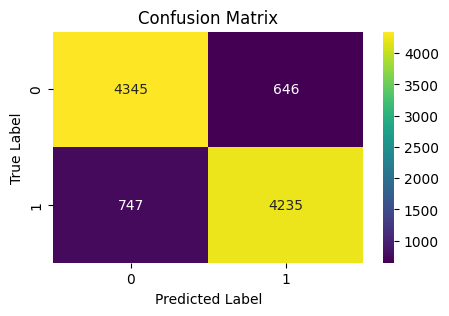

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # Create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    print("Shape of stackedX:", stackedX.shape)
    print("Shape of inputy:", inputy.shape)
    # Define the MLPClassifier
    model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500)
    # Perform cross-validation
    cv_scores = cross_val_score(model, stackedX, inputy, cv=5, scoring='accuracy')
    print(f'Cross-validation scores: {cv_scores}')
    print(f'Mean cross-validation score: {cv_scores.mean()}')
    # Fit the model on the entire dataset
    model.fit(stackedX, inputy)
    return model

# Load all models
members = load_all_models()
print('Loaded the models')

# Fit the stacked model
modelStacked = fit_stacked_model(members, train_indices, Y_train)
print('Stacked model fitted')

# Function to make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # Create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # Make a prediction
    yhat = model.predict(stackedX)
    return yhat

# Evaluate the proposed model (MDSA) on the test set
yhat = stacked_prediction(members, modelStacked, test_indices)

# Calculate accuracy
accuracy = accuracy_score(Y_test, yhat)
print(f'The accuracy score of the stacked model is: {accuracy}')

# Generate classification report
class_report = classification_report(Y_test, yhat, target_names=['0', '1'])
print(f'Classification Report:\n{class_report}')

# Additional metrics: Precision, Recall, F1-score
precision = precision_score(Y_test, yhat, average='weighted')
recall = recall_score(Y_test, yhat, average='weighted')
f1 = f1_score(Y_test, yhat, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Generate confusion matrix
conf_matrix = confusion_matrix(Y_test, yhat)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()